### 1 — Imports and Constants

In [6]:
import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
import numpy as np
import pandas as pd
import cv2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

IMG_SIZE = 224
BATCH_SIZE = 32

### 2 — Preprocessing Function

In [7]:
# Preprocessing function for tf.data pipeline
def preprocess_tf(path, label):
    # Read image
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)  # grayscale
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    # Convert grayscale to RGB for potential pre-trained models
    img = tf.image.grayscale_to_rgb(img)
    return img, label

In [8]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("signature_dataset.csv")

df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

### 3 — Create tf.data Datasets

In [9]:
# Training dataset
train_ds = tf.data.Dataset.from_tensor_slices(
    (df_train["image_path"].values, df_train["label"].values)
)
train_ds = (
    train_ds
    .map(preprocess_tf, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Validation dataset
val_ds = tf.data.Dataset.from_tensor_slices(
    (df_test["image_path"].values, df_test["label"].values)
)
val_ds = (
    val_ds
    .map(preprocess_tf, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


### 4 — Compute Class Weights

In [10]:
classes = np.unique(df_train['label'].values)
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=df_train['label'].values
)
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)

Class weights: {0: 0.9486111111111111, 1: 1.0548262548262548, 2: 1.1852494577006507, 3: 0.7907380607814761, 4: 1.1242798353909464}


### 5 — Build Model (CNN / Fine-Tuning Ready)

In [13]:
NUM_CLASSES = len(classes)

# MobileNetV2 base
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # freeze for initial training

# Final model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2422597 (9.24 MB)
Trainable params: 1646

### 6 — Train Model (Phase 1)

In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10


86/86 [==============================] - 117s 953ms/step - loss: 1.6883 - accuracy: 0.2848 - val_loss: 1.3504 - val_accuracy: 0.4284
Epoch 2/10
86/86 [==============================] - 36s 396ms/step - loss: 1.3274 - accuracy: 0.4217 - val_loss: 1.2410 - val_accuracy: 0.5190
Epoch 3/10
86/86 [==============================] - 36s 402ms/step - loss: 1.2147 - accuracy: 0.4813 - val_loss: 1.1687 - val_accuracy: 0.5380
Epoch 4/10
86/86 [==============================] - 43s 473ms/step - loss: 1.1445 - accuracy: 0.5311 - val_loss: 1.1197 - val_accuracy: 0.5556
Epoch 5/10
86/86 [==============================] - 37s 408ms/step - loss: 1.0821 - accuracy: 0.5549 - val_loss: 1.0746 - val_accuracy: 0.5892
Epoch 6/10
86/86 [==============================] - 39s 436ms/step - loss: 1.0338 - accuracy: 0.5776 - val_loss: 1.0210 - val_accuracy: 0.6038
Epoch 7/10
86/86 [==============================] - 38s 401ms/step - loss: 0.9870 - accuracy: 0.5988 - val_loss: 0.9998 - val_accuracy: 0.5

### 7 — Fine-Tune Top Layers (Phase 2)

In [15]:
# Unfreeze last 30 layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Keep BatchNorm layers frozen
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10
86/86 [==============================] - 45s 472ms/step - loss: 0.8362 - accuracy: 0.6541 - val_loss: 0.8235 - val_accuracy: 0.6813
Epoch 2/10
86/86 [==============================] - 46s 515ms/step - loss: 0.7552 - accuracy: 0.6955 - val_loss: 0.7753 - val_accuracy: 0.6886
Epoch 3/10
86/86 [==============================] - 43s 481ms/step - loss: 0.6932 - accuracy: 0.7123 - val_loss: 0.6698 - val_accuracy: 0.7442
Epoch 4/10
86/86 [==============================] - 43s 480ms/step - loss: 0.6147 - accuracy: 0.7518 - val_loss: 0.6247 - val_accuracy: 0.7544
Epoch 5/10
86/86 [==============================] - 44s 479ms/step - loss: 0.5873 - accuracy: 0.7698 - val_loss: 0.6418 - val_accuracy: 0.7398
Epoch 6/10
86/86 [==============================] - 43s 478ms/step - loss: 0.5334 - accuracy: 0.7965 - val_loss: 0.5769 - val_accuracy: 0.7792
Epoch 7/10
86/86 [==============================] - 43s 478ms/step - loss: 0.4970 - accuracy: 0.8111 - val_loss: 0.5554 - val_accuracy: 0.7734

### 8 — Evaluate Model on Test Data

In [16]:
test_loss, test_accuracy = model.evaluate(val_ds)
print(f"Test Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")

22/22 [==============================] - 8s 340ms/step - loss: 0.4571 - accuracy: 0.8319
Test Loss     : 0.4571
Test Accuracy : 0.8319


### 9 — Confusion Matrix and Classification Report

In [17]:
# Predict on validation dataset
y_true = np.concatenate([y for _, y in val_ds], axis=0)
y_pred = np.argmax(model.predict(val_ds), axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

22/22 [==============================] - 8s 306ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.90      0.80       144
           1       0.91      0.81      0.85       130
           2       0.87      1.00      0.93       115
           3       0.93      0.65      0.76       173
           4       0.79      0.89      0.84       122

    accuracy                           0.83       684
   macro avg       0.84      0.85      0.84       684
weighted avg       0.85      0.83      0.83       684

Confusion Matrix:
[[129   2   4   4   5]
 [ 11 105   5   2   7]
 [  0   0 115   0   0]
 [ 30   8   7 112  16]
 [  9   1   1   3 108]]


### 10 — Save Model

In [18]:
model.save("signature_model_tfdata.keras")

### 11 — Load Model for Single Image Prediction

In [19]:
model = tf.keras.models.load_model("signature_model_tfdata.keras")

In [20]:
model.summary()
model.predict(val_ds)
model.evaluate(val_ds)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2422597 (9.24 MB)
Trainable params: 1675

[0.4570702016353607, 0.8318713307380676]

### 12 — Single Image Prediction Function

In [21]:
def predict_image_tfdata(image_path, model, class_names):
    # Preprocess
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = tf.image.grayscale_to_rgb(img)
    img = tf.expand_dims(img, axis=0)  # (1,224,224,3)
    
    preds = model.predict(img)
    class_id = np.argmax(preds)
    confidence = np.max(preds)
    return class_names[class_id], confidence

In [22]:
def preprocess_signature(image_path):
    # Load image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Noise removal (Gaussian blur)
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    
    # Binarization (Otsu's thresholding)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Deskewing (find skew angle and rotate)
    coords = np.column_stack(np.where(binary > 0))
    angle = 0
    (h, w) = binary.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    deskewed = cv2.warpAffine(binary, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    # Display
    plt.imshow(deskewed, cmap='gray')
    plt.title('Preprocessed Signature')
    plt.show()

### 13 — Example Usage of Single Image Prediction

1/1 [==============================] - 1s 867ms/step
Predicted Label : Conscientiousness
Confidence     : 0.6899898


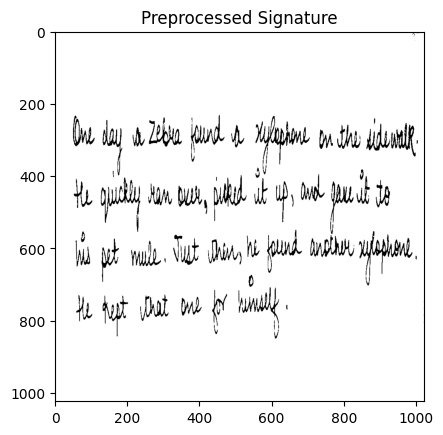

In [23]:
class_names = sorted(df_train['label'].unique().astype(str))

label_dict = {
    0 : "Agreeableness",
    1 : "Conscientiousness",
    2 : "Extraversion",
    3 : "Neuroticism",
    4 : "Openness",
}

image_path = "heavy_handwriting_dataset/test_set/Conscientiousness/IMG_20200215_174809-1.jpg"

pred_label, confidence = predict_image_tfdata(image_path, model, class_names)

print("Predicted Label :", label_dict[int(pred_label)])
print("Confidence     :", confidence)
result = preprocess_signature(image_path)